# <font size="4" color='black'>Self Implementation of DefaultModelMonitor</font>

Define a simple regression use case

This use case has two columns. Age and Salary. Our input is Age and label is Salary. 
We are looking to build models and predict Salary for any given Age.
The purpose is to demonstrate how this can be done using MLOps.

## <center><font size="5" color='black'> ------------- Section 01 - FE and Training ------------- </font>

## <font size="3" color='blue'>Get Input DataSet, perform FE, train-test split</font>

In [2]:
# get London time

from datetime import datetime
import pytz
import os

def read(s3_url):
    
    file_path = fr'{s3_url}'
    file_name = os.path.basename(file_path)
    
    !rm ./tmp/$file_name 2> /dev/null
    
    # print verbose if error
    !aws s3 cp $file_path  ./tmp/ | grep 'fatal error'
    !cat ./tmp/$file_name
    
def get_london_time():
    tz_London = pytz.timezone('Europe/London')
    tm_London = datetime.now(tz_London).strftime("%Y%m%d%H%M%S")
    return tm_London

### <font size="2" color='blue'>Input DataSet<font>

In [3]:
# A SageMaker session is needed to establish a connection between the notebook and AWS SageMaker services, enabling streamlined management of resources like training jobs and model deployments. It simplifies interactions with SageMaker by abstracting complex API calls, facilitating efficient machine learning workflows.

import sagemaker
from sagemaker.session import Session

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
import pandas as pd

In [5]:
input_data_for_training = pd.read_csv(r'../data/input-data-for-training.csv')
input_data_for_training.head()

,age,salary
0,20,30254
1,20,32367
2,20,11000
3,20,19000
4,20,14000


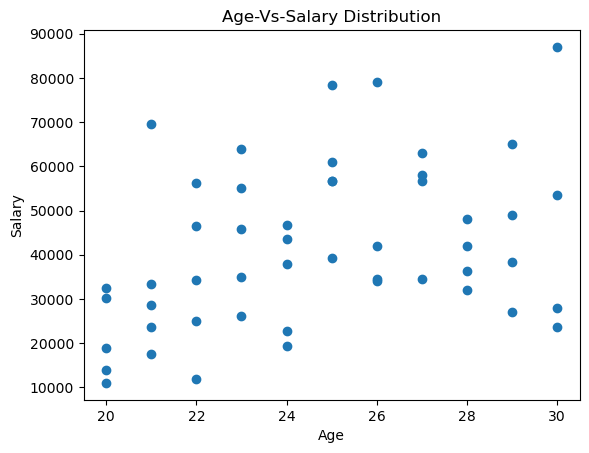

In [6]:
import matplotlib.pyplot as plt

x = input_data_for_training.age
y = input_data_for_training.salary

plt.scatter(x, y)
plt.title("Age-Vs-Salary Distribution")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.show()

In [7]:
# Split the dataset for training

from sklearn.model_selection import train_test_split 


X_train, X_test, y_train, y_test = train_test_split(
                                    input_data_for_training.age, 
                                    input_data_for_training.salary,
                                    random_state=104,  
                                    test_size=0.3,  
                                    shuffle=True
                                    ) 

In [8]:
print(f'input_data_for_training.shape : {input_data_for_training.shape}')
print(f'X_train : {len(X_train)} y_train : {len(y_train)}')
print(f'X_test  : {len(X_test)} y_test  : {len(y_test)}')

input_data_for_training.shape : (50, 2)
X_train : 35 y_train : 35
X_test  : 15 y_test  : 15


### <font size="2" color='blue'>Create a dummy feature engineering function<font>

In [9]:
def perform_feature_engineering(raw_data_df):
    # this is a dummy feature engineering function.
    # in real-case, it can be replace with more sophisticated code
    # that perform feature engineering and derive new features
    return raw_data_df

In [10]:
input_data_for_training = perform_feature_engineering(input_data_for_training)
input_data_for_training.head(5)

,age,salary
0,20,30254
1,20,32367
2,20,11000
3,20,19000
4,20,14000


In [11]:
train_df = pd.DataFrame({'y_salary' : y_train, 'x_age' : X_train})
print(f'train_df.shape : {train_df.shape}')
train_df.head(3)

train_df.shape : (35, 2)


,y_salary,x_age
30,42000,26
12,25000,22
41,42000,28


In [12]:
valid_df = pd.DataFrame({'y_salary' : y_test, 'x_age' : X_test})
print(f'valid_df.shape : {valid_df.shape}')
valid_df.head(3)

valid_df.shape : (15, 2)


,y_salary,x_age
20,22651,24
26,61000,25
7,17500,21


In [13]:
train_df.to_csv(r'../data/train_df.csv', index=False, header=False)
valid_df.to_csv(r'../data/valid_df.csv', index=False, header=False)

In [14]:
#Madan: create function to save files into S3
import boto3

def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = file_name
        
    # Upload the file
    s3 = boto3.client('s3')
    try:
        s3.upload_file(file_name, bucket, object_name)
        print(f"Uploaded {file_name} to S3 bucket {bucket} as {object_name}")
    except Exception as e:
        print(f"Error uploading file: {e}")

In [15]:
#Madan:  upload Train into s3
file_name = r'../data/train_df.csv'
bucket_name= "01-attempts-406016308324"
object_name= "pipelines/use_case_ageVsSalary/input_data_for_training/train/train_df.csv"
upload_file(file_name,bucket_name,object_name)


file_name = r'../data/valid_df.csv'
bucket_name= "01-attempts-406016308324"
object_name= "pipelines/use_case_ageVsSalary/input_data_for_training/valid/valid_df.csv"
upload_file(file_name,bucket_name,object_name)

Uploaded ../data/train_df.csv to S3 bucket 01-attempts-406016308324 as pipelines/use_case_ageVsSalary/input_data_for_training/train/train_df.csv
Uploaded ../data/valid_df.csv to S3 bucket 01-attempts-406016308324 as pipelines/use_case_ageVsSalary/input_data_for_training/valid/valid_df.csv


### <font size="2" color='blue'>Retrieve base image URI and run the training through processing job<font>

In [16]:
# getting the linear learner image according to the region
import boto3
from sagemaker.image_uris import retrieve

base_image = retrieve("linear-learner", boto3.Session().region_name, version="1")
print(f'base_image : {base_image}')

base_image : 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [17]:
train_location=r's3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/input_data_for_training/train/train_df.csv'
validation_location=r's3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/input_data_for_training/valid/valid_df.csv'

train_config=sagemaker.session.TrainingInput(
    s3_data=train_location,
    content_type='text/csv',
    s3_data_type='S3Prefix')

validation_config=sagemaker.session.TrainingInput(
    s3_data=validation_location,
    content_type='text/csv',
    s3_data_type='S3Prefix')

data_channels={'train':train_config,'validation':validation_config}

print(train_config.config)
print(validation_config.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/input_data_for_training/train/train_df.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/input_data_for_training/valid/valid_df.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}


In [18]:
output_location = r's3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/output/'

linear_estimator = sagemaker.estimator.Estimator(
                                                    base_image,
                                                    role,
                                                    input_mode="File",
                                                    instance_count=1,
                                                    instance_type="ml.m4.xlarge",
                                                    output_path=output_location,
                                                    sagemaker_session=sagemaker_session
                                                )

In [19]:
# Note: set hyperparameter as training job was failing with below error </br></br>

# ClientError: No value(s) were specified for 'predictor_type' which are required hyperparameter(s) (caused by ValidationError), exit code: 2
# set hyperparameters 
linear_estimator.set_hyperparameters(
        feature_dim=1,
        mini_batch_size=1,
        predictor_type='regressor')

In [20]:
# this will trigger processing job

# Concise description of each SageMaker job:

# Training Job: Trains a machine learning model using a specified algorithm and dataset.
# Processing Job: Executes data preprocessing, postprocessing, or any custom processing tasks.
# Transform Job (Batch Inference Job): Applies a trained model to a large dataset for batch predictions.
# Inference Job (Endpoint): Deploys a trained model as a real-time endpoint for online predictions.
# Hyperparameter Tuning Job: Automatically searches for the best hyperparameters to optimize model performance.
# Data Wrangler Job: Processes and visualizes data using a graphical interface to prepare it for machine learning tasks.

# defining train_data, the LinearLearner algorithm expects the data to be in a specific format, typically as a CSV file or in the record-IO protobuf format. The dataset should be in a tabular format where the first column is the label (target variable) and the remaining columns are the features.


job_name = "AgeVsSalary-linear-learner-train-job-" + get_london_time()
print("Training job", job_name)

linear_estimator.fit(inputs=data_channels, job_name=job_name)

INFO:sagemaker:Creating training-job with name: AgeVsSalary-linear-learner-train-job-20240809153258


Training job AgeVsSalary-linear-learner-train-job-20240809153258
2024-08-09 14:33:00 Starting - Starting the training job...
2024-08-09 14:33:14 Starting - Preparing the instances for training...
2024-08-09 14:33:42 Downloading - Downloading input data...
2024-08-09 14:34:12 Downloading - Downloading the training image......
2024-08-09 14:35:33 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/09/2024 14:35:51 INFO 140693528368960] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init

### <font size="2" color='blue'>Create simple function to print evaluation metrics</font>

### <font size="2" color='blue'>Store the trained model image for repeated use</font>

In [22]:
trained_model=fr'{output_location}/{job_name}/output/model.tar.gz'
print(trained_model)

s3://01-attempts-406016308324/pipelines/use_case_ageVsSalary/output//AgeVsSalary-linear-learner-train-job-20240809153258/output/model.tar.gz


In [24]:
# remember to delete endpoint after use

model_name="AgeVsSalary-model-" + get_london_time()
endpoint_name = "AgeVsSalary-Endpoint-" + get_london_time()

predictor = linear_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name = endpoint_name)

INFO:sagemaker:Creating model with name: linear-learner-2024-08-09-14-38-40-027
INFO:sagemaker:Creating endpoint-config with name AgeVsSalary-Endpoint-20240809153840
INFO:sagemaker:Creating endpoint with name AgeVsSalary-Endpoint-20240809153840


--------!b'{"predictions": [{"score": 49989.2265625}]}'


In [25]:
from sagemaker.serializers import CSVSerializer

predictor.serializer = CSVSerializer()
result = predictor.predict([[30]])
print(result)

b'{"predictions": [{"score": 49989.2265625}]}'


### <font size="2" color='blue'>Delete model to avoid unnecessary cost</font>

In [26]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: AgeVsSalary-Endpoint-20240809153840
INFO:sagemaker:Deleting endpoint with name: AgeVsSalary-Endpoint-20240809153840


## <center><font size="5" color='black'> ------------- Section 02 - Batch Transform ------------- </font>

## <font size="3" color='green'>Create Code to input data, generate inferences using batch transform</font>

### <font size="2" color='green'>Get a very simple dataset of age and salary with some randomness</font> 

1. See data folder. 

### <font size="2" color='green'>Create a code to generate inference using batch transform</font> 

### <font size="2" color='green'>Provide a sample batch input file and generate inferences</font>

### <font size="2" color='green'>Create sagemaker pipeline to train model and generate inference again when a new train input file is loaded</font>

## <center><font size="5" color='black'> ------------- Section 03 - Pipeline ------------- </font>

## <font size="3" color='red'>Create a sample pipeline on existing train data</font>

### <font size="2" color='red'>Execute pipeline and generate inference on existing train data</font>

### <font size="2" color='red'>Upload new train data and generate inference by executing pipeline</font>

## <center><font size="5" color='black'> ------------- Section 04 - DefaultModelMonitor ------------- </font>

## <font size="3" color='blue'>DefaultModelMonitor : Create code to monitor data quality and accept/reject batch input file based on constraints</font>

### <font size="2" color='blue'>Code for monitor data quality config and job using DefaultModelMonitor</font>

### <font size="2" color='blue'>Get a batch input file with outlier that the monitor data quality step should REJECT</font>

### <font size="2" color='blue'>Get a batch input file with outlier that the monitor data quality step should ACCEPT</font>

## <center><font size="5" color='black'> ------------- Section 05 - ModelMonitor ------------- </font>

## <font size="3" color='green'>ModelMonitor : Create code to monitor data quality and accept/reject batch input file based on constraints</font>

### <font size="2" color='green'>Code for monitor data quality config and job using ModelMonitor</font>

### <font size="2" color='green'>Get a batch input file with outlier that the monitor data quality step should REJECT</font>

### <font size="2" color='green'>Get a batch input file with outlier that the monitor data quality step should ACCEPT</font>

# <font size="4" color='black'>End Of Notebook</font>